# AOD

## langley calibration

### load calibration

In [1]:
import helpers

In [2]:
import atmPy.radiation.retrievals.langley_calibration as atmlc

<xarray.Dataset> Size: 168B
Dimensions:     (wavelength: 6)
Coordinates:
  * wavelength  (wavelength) int32 24B 415 500 670 870 940 1625
Data variables:
    V0          (wavelength) float64 48B 7.886 7.241 6.655 7.509 7.718 6.219
    V0_std      (wavelength) float64 48B 0.0 0.0 0.0 0.0 0.0 0.0
    V0_stderr   (wavelength) float64 48B 0.001221 0.001247 ... 0.001458 0.001511

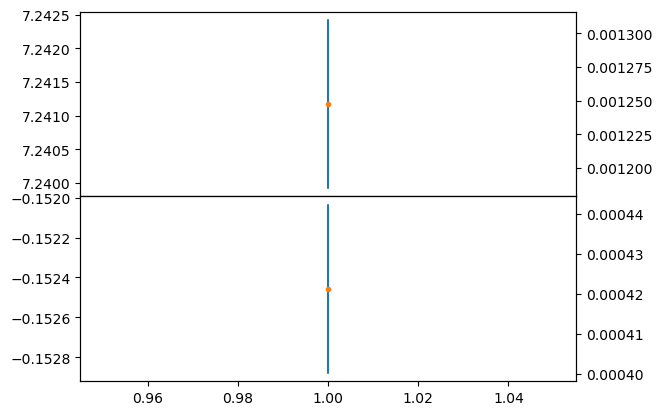

In [3]:
p2fld = pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.langleys/v0.2/')
lt = atmlc.open_langleys(p2fld)
lt648 = lt
lt.plot_ranked(wl = 500)
lt.V0_simple

<xarray.Dataset> Size: 168B
Dimensions:     (wavelength: 6)
Coordinates:
  * wavelength  (wavelength) int32 24B 415 500 670 870 940 1625
Data variables:
    V0          (wavelength) float64 48B 7.988 7.233 6.776 7.615 7.787 6.255
    V0_std      (wavelength) float64 48B 0.003772 0.0007407 ... 0.05823 0.006433
    V0_stderr   (wavelength) float64 48B 0.001153 0.001047 ... 0.001746 0.001725

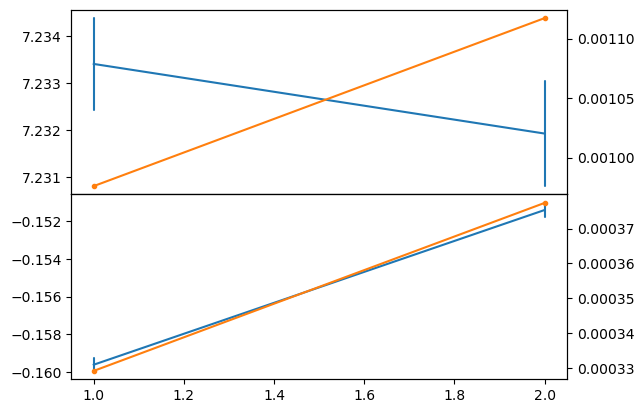

In [4]:
p2fld = pl.Path('/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/649.langleys/v0.2/')
lt = atmlc.open_langleys(p2fld)
lt649 = lt
lt.plot_ranked(wl = 500)
lt.V0_simple

### Load a file

## calibrate to irradiance

In [5]:
import atmPy.radiation.rayleigh.lab as atmray

In [6]:
reload(atmray)

<module 'atmPy.radiation.rayleigh.lab' from '/home/hagen/prog/atm-py/atmPy/radiation/rayleigh/lab.py'>

In [7]:
def htalt(wl = 500, pressure = 844):
    lam = wl * 1e-3
    od = (pressure/ 1013.25) * 0.008569 * lam**-4 * (1.0 + 0.0133 * lam**-2 + 0.00013 * lam**-4)
    return od

In [8]:
atmray.rayleigh_od_first_principles(500, 844)

np.float64(0.11898754913106524)

In [9]:
wl = 415
pressure = 844
od_ht = atmray.rayleigh_od_ht(wl, pressure)
od_ht_alt = htalt(wl, pressure)
print(f'ht: {od_ht: 0.5f} ht_alt: {od_ht_alt:0.5f}, diff to alt: {od_ht - od_ht_alt: 0.5f}')
atmray.rayleigh_od_johnsmethod(pressure, wl) - atmray.rayleigh_od_first_principles(wl, pressure)
atmray.rayleigh_od_ht(wl, pressure) - atmray.rayleigh_od_first_principles(wl, pressure), htalt(wl, pressure) - atmray.rayleigh_od_first_principles(wl, pressure)

ht:  0.25748 ht_alt: 0.26028, diff to alt: -0.00279


(np.float64(0.0012872486846541853), np.float64(0.004081705434885008))

### what should the TOA irradiance be at that day, actually so the earth-sun distance is in full disply 

In [10]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec

In [196]:
reload(atmspec)

<module 'atmPy.radiation.retrievals.spectral_irradiance' from '/home/hagen/prog/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py'>

In [ ]:
serial_no = 648
fn = '/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/frc_648_v0.1_20250929.nc'
fnmet = '/nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250929_preliminary.nc'
ds = xr.open_dataset(fn)
dsmet = xr.open_dataset(fnmet)
gdd = atmspec.CombinedGlobalDiffuseDirect(ds.copy())
gdd.dataset['channel_wavelength'] = gdd.dataset.channel_wavelength.astype(float) #error in processing upstream, fix it in future versions!
gdd = gdd.apply_calibration_langley(lt648)

dni = gdd.direct_normal_irradiation
# dni.raw_data = dni.raw_data.where(dni.raw_data.channel < 1000, drop = True)
dni.met_data = dsmet
# dni.precipitable_water_varname = 'precipitable_water_aeronet'
dni.precipitable_water = 1

dni.met_data = fnmet
dni.ozone_data = 300
dni.raw_data.attrs['serial_no'] = serial_no
# dni.mfrsr_history = None
dni.aod.plot.line(x = 'datetime')
dni648 = dni

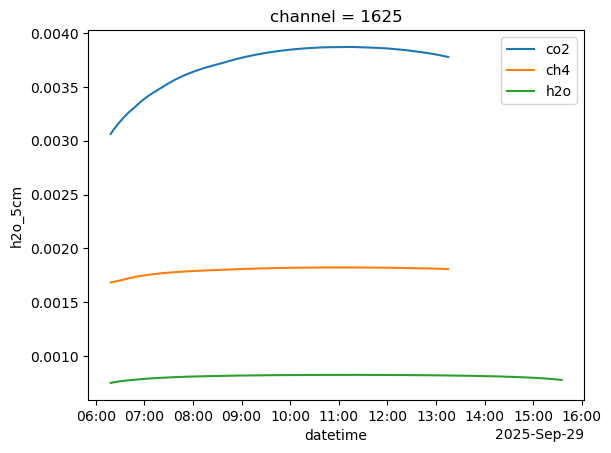

In [242]:
f, a= plt.subplots()
dst = dni648.od_co2_ch4_h2o.sel(channel = 1625)
dst.co2.plot(ax = a, label = 'co2')
dst.ch4.plot(ax = a, label = 'ch4')
dst.h2o_5cm.plot(ax = a, label = 'h2o')
a.legend()

In [239]:
dni648.od_co2_ch4_h2o

<xarray.Dataset> Size: 427kB
Dimensions:   (channel: 6, datetime: 2806)
Coordinates:
  * channel   (channel) int64 48B 1625 415 500 670 870 940
  * datetime  (datetime) datetime64[ns] 22kB 2025-09-29 ... 2025-09-29T15:35:...
Data variables:
    co2       (channel, datetime) float64 135kB nan nan nan nan ... 0.0 0.0 0.0
    ch4       (channel, datetime) float64 135kB nan nan nan nan ... 0.0 0.0 0.0
    h2o_5cm   (channel, datetime) float64 135kB nan nan nan nan ... 0.0 0.0 0.0

In [206]:
# %matplotlib widget

In [220]:
%matplotlib inline

(-0.01, 0.04)

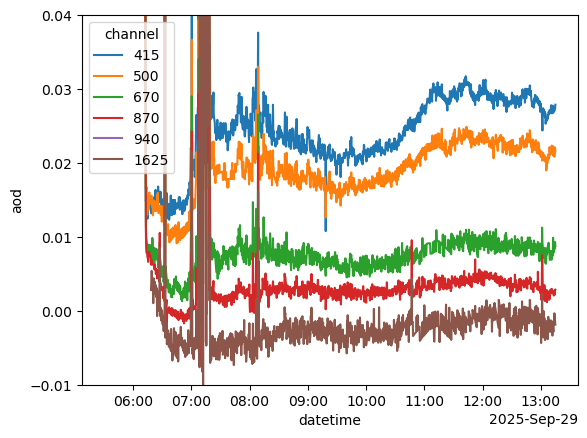

In [226]:
f,a = plt.subplots()
dni648.aod.plot.line(x = 'datetime', ax = a)
a.set_ylim(-0.01, 0.04)

## compare to others

In [208]:
p2fld = pl.Path('/nfs/grad/campaign/frc/2025/AOD/')

In [209]:
list(p2fld.glob('**/*'))

[PosixPath('/nfs/grad/campaign/frc/2025/AOD/DE_PTB_CAS'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/US_NOAA_HSR1'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/ES_AEMET_CE'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/FR_LOA.UoL_CE'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/DE_PTB_SSIM'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/ES_UVa_MTS'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/DE_PTB_CAS-IR'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/SE_SMHI_PFR'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/ES_UV_POM'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/JP_JMA_POM'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/ES_CIEMAT_BTS'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/DE_DWD_PFR-F'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/CN_CMA_CW193'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#9'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/ES_AEMET_CLT'),
 PosixPath('/nfs/grad/campaign/frc/2025/AOD/DE_

In [227]:
import helpers

In [228]:
reload(helpers)

<module 'helpers' from '/home/hagen/projecte/cmpaign_2025_PMOD/helpers.py'>

In [229]:
p2f = pl.Path('/nfs/grad/campaign/frc/2025/AOD/JP_JMA_POM/JP_JMA_POM_20250929.aod')
ds = helpers.read_JP_JMA_POM(p2f)
ds_jp_jma_pom = ds
ds

<xarray.Dataset> Size: 41kB
Dimensions:   (datetime: 469, channel: 10)
Coordinates:
  * datetime  (datetime) datetime64[ns] 4kB 2025-09-29T06:20:00 ... 2025-09-2...
  * channel   (channel) int64 80B 340 380 400 500 675 870 1020 1225 1627 2200
Data variables:
    aod       (datetime, channel) float64 38kB 0.0312 0.0333 ... 0.0065 0.0369

(-0.01, 0.05)

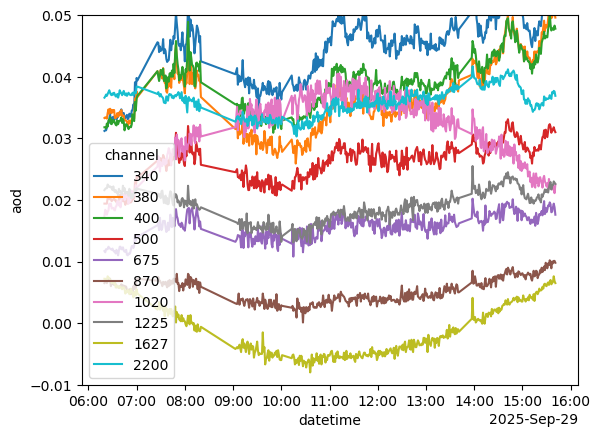

In [230]:
f,a = plt.subplots()
ds_jp_jma_pom.aod.plot.line(x = 'datetime')
a.set_ylim(-0.01,0.05)

In [231]:
p2f = pl.Path('/nfs/grad/campaign/frc/2025/AOD/SE_SMHI_PFR/SE_SMHI_PFR_20250929.aod')
ds = helpers.read_SE_SMHI_PFR(p2f)
ds_se_smhi_pfr = ds

(-0.01, 0.05)

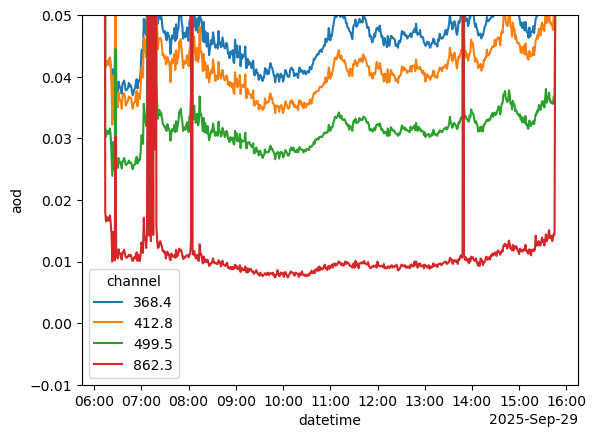

In [232]:
f,a = plt.subplots()
ds.aod.plot.line(x = 'datetime', ax = a)
a.set_ylim(-0.01, 0.05)

In [37]:
ds_jp_jma_pom.channel

<xarray.DataArray 'channel' (channel: 10)> Size: 80B
array([ 340,  380,  400,  500,  675,  870, 1020, 1225, 1627, 2200])
Coordinates:
  * channel  (channel) int64 80B 340 380 400 500 675 870 1020 1225 1627 2200

In [233]:
ds_se_smhi_pfr.channel

<xarray.DataArray 'channel' (channel: 4)> Size: 32B
array([368.4, 412.8, 499.5, 862.3])
Coordinates:
  * channel  (channel) float64 32B 368.4 412.8 499.5 862.3

(-0.01, 0.04)

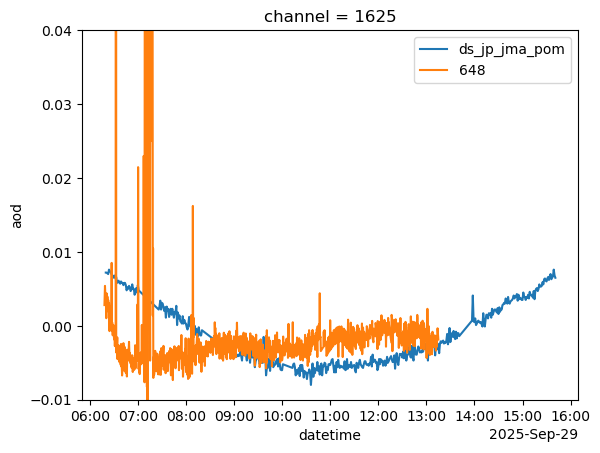

In [234]:
f,a = plt.subplots()
# ds_se_smhi_pfr.aod.sel(channel = 862.3).plot(ax = a, label = p2f.name)
ds_jp_jma_pom.aod.sel(channel = 1627).plot(ax = a, label = 'ds_jp_jma_pom')
dni648.aod.sel(channel = 1625).plot(ax = a, label = '648')
# dni649.aod.sel(channel = 1625).plot(ax = a, label = '649')

a.legend()
a.set_ylim(-0.01, 0.04)

(-0.01, 0.04)

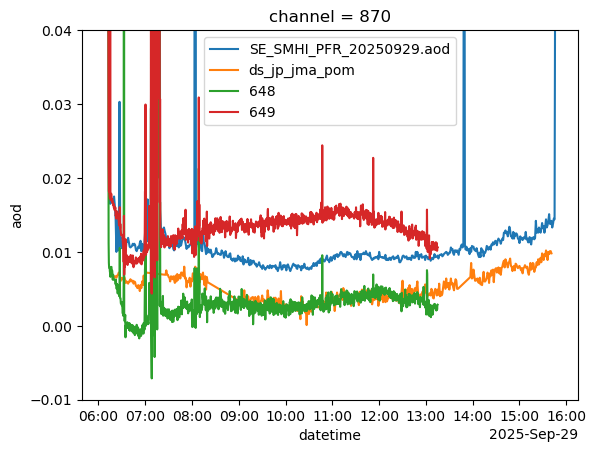

In [39]:
f,a = plt.subplots()
ds_se_smhi_pfr.aod.sel(channel = 862.3).plot(ax = a, label = p2f.name)
ds_jp_jma_pom.aod.sel(channel = 870).plot(ax = a, label = 'ds_jp_jma_pom')
dni648.aod.sel(channel = 870).plot(ax = a, label = '648')
dni649.aod.sel(channel = 870).plot(ax = a, label = '649')

a.legend()
a.set_ylim(-0.01, 0.04)

(-0.01, 0.04)

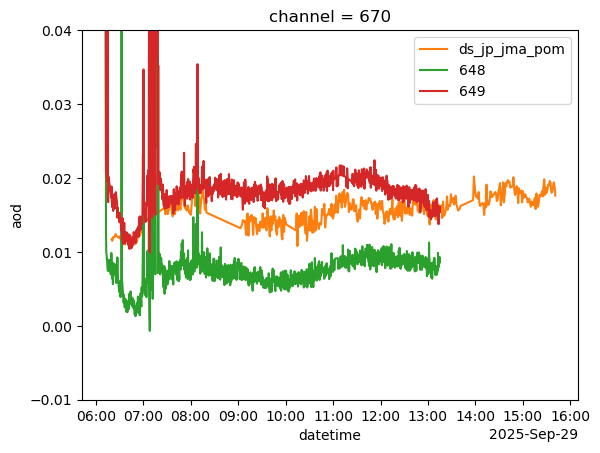

In [42]:
f,a = plt.subplots()
# ds_se_smhi_pfr.aod.sel(channel = 862.3).plot(ax = a, label = p2f.name)
a._get_lines.get_next_color()
ds_jp_jma_pom.aod.sel(channel = 675).plot(ax = a, label = 'ds_jp_jma_pom')
dni648.aod.sel(channel = 670).plot(ax = a, label = '648')
dni649.aod.sel(channel = 670).plot(ax = a, label = '649')

a.legend()
a.set_ylim(-0.01, 0.04)

(-0.01, 0.04)

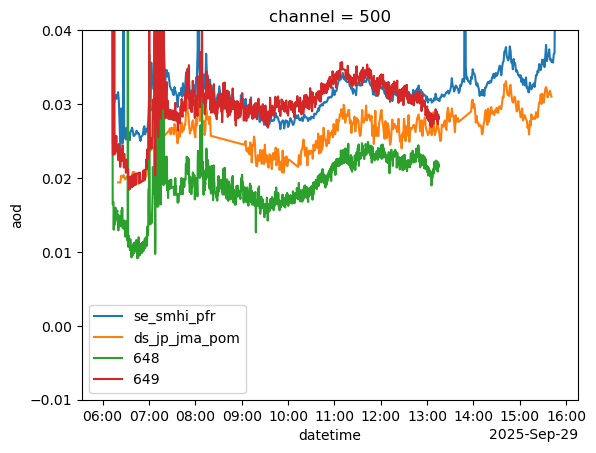

In [40]:
f,a = plt.subplots()
ds_se_smhi_pfr.aod.sel(channel = 499.5).plot(ax = a, label = 'se_smhi_pfr')
ds_jp_jma_pom.aod.sel(channel = 500).plot(ax = a, label = 'ds_jp_jma_pom')
dni648.aod.sel(channel = 500).plot(ax = a, label = '648')
dni649.aod.sel(channel = 500).plot(ax = a, label = '649')
a.legend()
a.set_ylim(-0.01, 0.04)

(-0.0, 0.06)

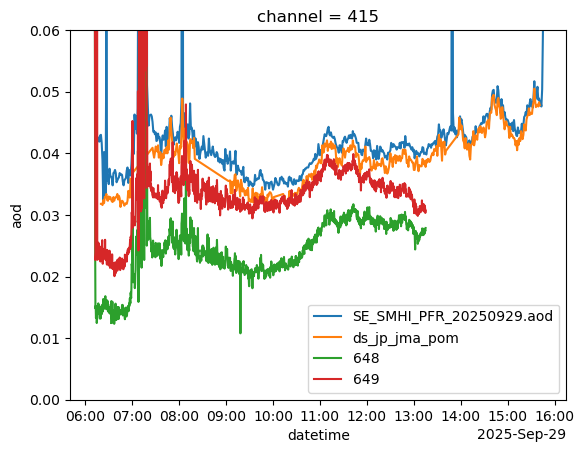

In [41]:
f,a = plt.subplots()#, gridspec_kw={'hspace': 0})
# a = aa[0]
ds_se_smhi_pfr.aod.sel(channel = 412.8).plot(ax = a, label = p2f.name)
ds_jp_jma_pom.aod.sel(channel = 400).plot(ax = a, label = 'ds_jp_jma_pom')
dni648.aod.sel(channel = 415).plot(ax = a, label = '648')
dni649.aod.sel(channel = 415).plot(ax = a, label = '649')

a.legend()
a.set_ylim(-0.0, 0.06)